# Rain gauges near the River Chess

In [1]:
import datetime
import numpy as np
import polars as pl
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
CHESS_XRANGE = [464000, 530000]
CHESS_YRANGE = [174000, 230000]
RAIN_COL = "rain_mm"

# 1. Load data

## Load rain gauge metadata 
From internal UKCEH Oracle Database

In [14]:
chess_daily = pl.read_csv('rain_gauge_data/chess_daily_rain_gauges_QConly.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])
chess_daily_metadata = pl.read_csv('rain_gauge_data/chess_daily_rain_gauges_metadata_QConly.csv', try_parse_dates=True)

In [15]:
chess_monthly = pl.read_csv('rain_gauge_data/chess_monthly_rain_gauges_QConly.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])
chess_monthly_metadata = pl.read_csv('rain_gauge_data/chess_monthly_rain_gauges_metadata_QConly.csv', try_parse_dates=True)

In [17]:
# Check for monthly only gauges in metadata
chess_daily_metadata = chess_daily_metadata.with_columns(
    (pl.col("ID").is_in(chess_monthly['gauge_id']) & ~pl.col("ID").is_in(chess_daily['gauge_id'].unique())).alias('IS_ONLY_MONTHLY_GAUGE')
)

chess_daily_metadata = chess_daily_metadata.with_columns(
    (~pl.col("ID").is_in(chess_monthly['gauge_id']) & pl.col("ID").is_in(chess_daily['gauge_id'].unique())).alias('IS_ONLY_DAILY_GAUGE')
)

print(chess_daily_metadata['IS_ONLY_DAILY_GAUGE'].value_counts())
print(chess_daily_metadata['IS_ONLY_MONTHLY_GAUGE'].value_counts())

shape: (2, 2)
┌─────────────────────┬───────┐
│ IS_ONLY_DAILY_GAUGE ┆ count │
│ ---                 ┆ ---   │
│ bool                ┆ u32   │
╞═════════════════════╪═══════╡
│ false               ┆ 93    │
│ true                ┆ 280   │
└─────────────────────┴───────┘
shape: (1, 2)
┌───────────────────────┬───────┐
│ IS_ONLY_MONTHLY_GAUGE ┆ count │
│ ---                   ┆ ---   │
│ bool                  ┆ u32   │
╞═══════════════════════╪═══════╡
│ false                 ┆ 373   │
└───────────────────────┴───────┘


## Load catchment boundaries
Downloaded from NRFA: https://nrfa.ceh.ac.uk/data/station/spatial/39088

In [18]:
chess_shp = gpd.read_file('../Spatial Data/Catchment Boundaries/Chess/nrfa_39088/NRFA_catchments.shp')

## Load gridded rainfall products
CEH-GEAR 1km extracted from local UKCEH store  
HadUK-Grid 1km extracted from JASMIN  

In [19]:
ceh_chess = xr.open_dataset('../CEH_GEAR/ceh_1km_chessregion_19700101_20230101.nc')
ceh_chess = ceh_chess.rename({'rainfall_amount': RAIN_COL})

ceh_chess = ceh_chess.sel(x=slice(*CHESS_XRANGE), y=slice(*CHESS_YRANGE))

In [20]:
haduk_chess = xr.open_mfdataset([f'../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_chessregion_19700101_19860831.nc',\
                f'../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_chessregion_19860901_20041231.nc',\
                 f'../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_chessregion_20050101_20221231.nc'])
haduk_chess = haduk_chess.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_chess = haduk_chess.drop_vars(('latitude', 'longitude'))
haduk_chess['time'] = haduk_chess['time'].dt.floor(freq='D')

haduk_chess = haduk_chess.sel(x=slice(*CHESS_XRANGE), y=slice(*CHESS_YRANGE))

## Load rivers
Downloaded from OpenRivers: https://www.ordnancesurvey.co.uk/products/os-open-rivers

In [21]:
## Load rivers linestrings
rvs_linestrings = gpd.read_file('../Spatial Data/oprvrs_essh_gb/data/WatercourseLink.shp')
rvs_linestrings = rvs_linestrings.dropna(subset=['name1'])
chess_linestrings = rvs_linestrings.loc[rvs_linestrings['name1'].str.contains('River Chess')]

# 2. Calculate difference between HadUK to CEH-GEAR
[Back to Index](#table-of-contents)

## Shift grid
Because the two gridded datasets are on a different grid, we need to shift CEH-GEAR 500 metres in the X and Y dimension

In [22]:
def coerse_data_into_haduk_format(data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    data = data.assign_coords(x=(data['x'] + offset))
    data = data.assign_coords(y=(data['y'] + offset))
    data = data.sel(x=xrange, y=yrange)
    return data


In [23]:
ceh_chess_shifted = coerse_data_into_haduk_format(ceh_chess, offset=500, xrange=slice(*CHESS_XRANGE), yrange=slice(*CHESS_YRANGE))

## Get difference between HadUK to CEH-GEAR

In [24]:
ceh_chess_shifted = ceh_chess_shifted.sel(time=slice(haduk_chess['time'].min(), haduk_chess['time'].max()))

In [25]:
ceh_haduk_diff = ceh_chess_shifted['rain_mm'] - haduk_chess['rain_mm']
diff_col_name = f'{RAIN_COL}_diff'
ceh_haduk_diff = ceh_haduk_diff.to_dataset(name=diff_col_name)
ceh_haduk_diff['min_dist'] = ceh_chess_shifted['min_dist']

# 3. Analysis

In [26]:
def get_gauge_metadata_on_date(gauge_data, metadata, date):
    gauges_on_date = gauge_data.filter(pl.col("time") == date)
    gauge_ids = gauges_on_date['gauge_id'].unique()
    metadata_on_date = metadata.filter(pl.col("ID").is_in(gauge_ids))
    return metadata_on_date

def plot_gauge_scatter(metadata_on_date, ax, **kwargs):
    for row in metadata_on_date.iter_rows(named=True):
        ax.scatter(row['EASTING'], row['NORTHING'], edgecolor='r', facecolor='None', linewidths=1.5, alpha=.8, **kwargs)
    return ax

In [27]:
example_datetime = datetime.datetime(year=1997, month=1, day=7)

In [28]:
daily_metadata_on_date = get_gauge_metadata_on_date(chess_daily, chess_daily_metadata, example_datetime)
daily_metadata_on_date

ID,NORTHING,EASTING,ELEVATION,START_DATE,END_DATE,IS_ONLY_MONTHLY_GAUGE,IS_ONLY_DAILY_GAUGE
i64,i64,i64,i64,datetime[μs],datetime[μs],bool,bool
169477,224700,477100,107,1982-02-01 00:00:00,2000-12-31 00:00:00,false,true
171975,227129,495958,100,1996-07-01 00:00:00,2014-10-31 00:00:00,false,false
172101,226200,491400,85,1985-01-01 00:00:00,2003-03-31 00:00:00,false,false
175107,227393,518175,90,1995-12-01 00:00:00,2019-06-30 00:00:00,false,false
175652,227000,503000,101,1984-01-01 00:00:00,2003-10-31 00:00:00,false,false
…,…,…,…,…,…,…,…
278932,192239,503792,42,1961-01-01 00:00:00,2024-09-30 00:00:00,false,false
279048,205641,484470,192,1994-01-01 00:00:00,2008-08-31 00:00:00,false,false
279271,196849,498868,127,1961-01-01 00:00:00,2017-02-28 00:00:00,false,false


<Axes: title={'center': 'time = 2020-01-01'}, xlabel='x', ylabel='y'>

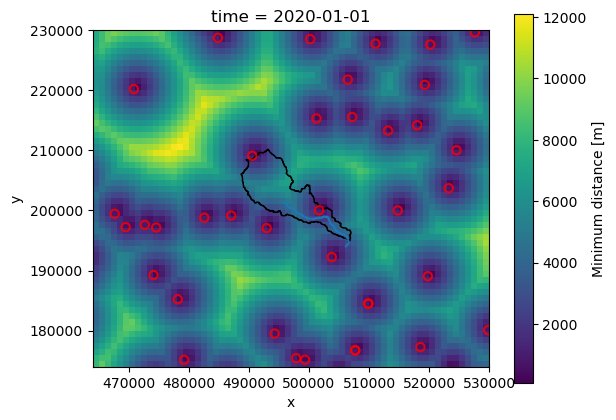

In [29]:
example_datetime = datetime.datetime(year=2020, month=1, day=1)
daily_metadata_on_date = get_gauge_metadata_on_date(chess_daily, chess_daily_metadata, example_datetime)

fig, ax = plt.subplots(1)
ceh_haduk_diff.sel(time=example_datetime)['min_dist'].plot(ax=ax)
chess_shp.plot(ax=ax, facecolor='none')
ax.set_xlim(CHESS_XRANGE)
ax.set_ylim(CHESS_YRANGE)
chess_linestrings.plot(ax=ax)
plot_gauge_scatter(metadata_on_date=daily_metadata_on_date, ax=ax)
# fig.savefig(f'figures/chess_gauges_and_distance_to_gauge_{example_datetime.strftime('%d_%b_%Y')}.png', bbox_inches='tight', dpi=150)

<Axes: title={'center': 'time = 1997-01-07'}, xlabel='x', ylabel='y'>

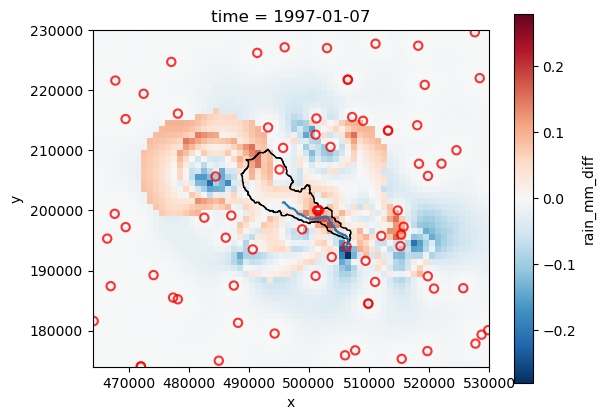

In [30]:
example_datetime = datetime.datetime(year=1997, month=1, day=7)
daily_metadata_on_date = get_gauge_metadata_on_date(chess_daily, chess_daily_metadata, example_datetime)

fig, ax = plt.subplots(1)

ceh_haduk_diff.sel(time=example_datetime)[f'{RAIN_COL}_diff'].plot(ax=ax)
chess_shp.plot(ax=ax, facecolor='none')
ax.set_xlim(CHESS_XRANGE)
ax.set_ylim(CHESS_YRANGE)
chess_linestrings.plot(ax=ax)
plot_gauge_scatter(metadata_on_date=daily_metadata_on_date, ax=ax)
# fig.savefig(f'figures/chess_gauges_and_ceh_vs_haduk_{example_datetime.strftime('%d_%b_%Y')}.png', bbox_inches='tight', dpi=150)

Text(0.5, 1.0, '1980:1990 CEH-GEAR vs HadUK-Grid')

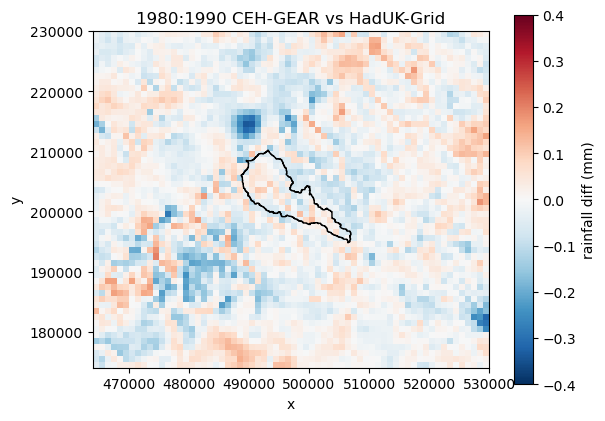

In [37]:
start_year, end_year = 1980, 1990
fig, ax = plt.subplots(1)
ceh_haduk_diff.sel(time=slice(str(start_year), str(end_year))).mean('time')[f'{RAIN_COL}_diff'].plot(ax=ax, vmin=-0.4, vmax=0.4, cmap='RdBu_r', cbar_kwargs={'label':'rainfall diff (mm)'})
chess_shp.plot(ax=ax, facecolor='none')
ax.set_xlim(CHESS_XRANGE)
ax.set_ylim(CHESS_YRANGE)
ax.set_title(f'{start_year}:{end_year} CEH-GEAR vs HadUK-Grid')
# fig.savefig(f'figures/chess_ceh_vs_haduk_{start_year}to{end_year}mean.png', bbox_inches='tight', dpi=150)

Text(0.5, 1.0, '1980:1990 CEH-GEAR vs HadUK-Grid')

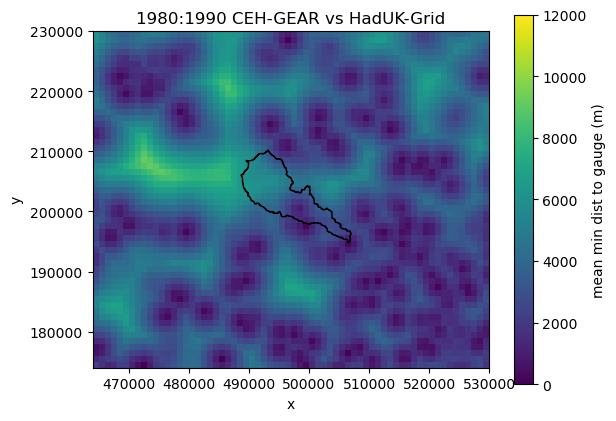

In [32]:
start_year, end_year = 1980, 1990
fig, ax = plt.subplots(1)
ceh_haduk_diff.sel(time=slice(str(start_year), str(end_year))).mean('time')[f'min_dist'].plot(ax=ax, vmax=12000, cbar_kwargs={'label':'mean min dist to gauge (m)'})
chess_shp.plot(ax=ax, facecolor='none')
ax.set_xlim(CHESS_XRANGE)
ax.set_ylim(CHESS_YRANGE)
ax.set_title(f'{start_year}:{end_year} CEH-GEAR vs HadUK-Grid')
# fig.savefig(f'figures/chess_min_dist_{start_year}to{end_year}mean.png', bbox_inches='tight', dpi=150)

## Compare one time period to another

In [34]:
ceh_haduk_diff_80to90 = ceh_haduk_diff.sel(time=slice(str(1980), str(1990))).mean('time')[f'{RAIN_COL}_diff']
ceh_haduk_diff_10to20 = ceh_haduk_diff.sel(time=slice(str(2010), str(2020))).mean('time')[f'{RAIN_COL}_diff']

ceh_haduk_diff_80to90_vs_10to20 = ceh_haduk_diff_80to90 - ceh_haduk_diff_10to20

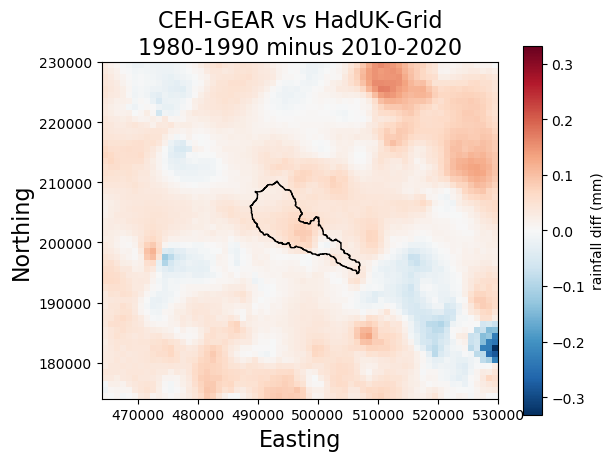

In [48]:

fig, ax = plt.subplots(1)
ceh_haduk_diff_80to90_vs_10to20.plot(ax=ax, cmap='RdBu_r', cbar_kwargs={'label':'rainfall diff (mm)'})
chess_shp.plot(ax=ax, facecolor='none')
ax.set_xlim(CHESS_XRANGE)
ax.set_ylim(CHESS_YRANGE)
ax.set_ylabel('Northing', size=16)
ax.set_xlabel('Easting', size=16)
ax.set_title(f'CEH-GEAR vs HadUK-Grid\n1980-1990 minus 2010-2020', size=16)
# fig.savefig(f'figures/chess_ceh_vs_haduk_decade_mean_diff.png', bbox_inches='tight', dpi=150)